In [49]:
import params 
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

In [2]:
train_data = np.load(params.datafile)
train_label = np.load(params.labelfile)

test_data = np.load(params.testfile)
test_label = np.load(params.testlabelfile)

In [3]:
print(train_data.shape)
print(test_data.shape)

(771232, 250)
(777419, 250)


57603 64675
[-9.000e+00-1.100e+01j -1.010e+02+1.200e+02j  5.000e+01+4.600e+01j
 -1.420e+02+3.020e+02j -1.920e+02+2.390e+02j -9.000e+00-2.300e+01j
 -1.020e+02-4.800e+01j -1.630e+02-9.000e+00j -4.700e+01+4.000e+01j
 -2.900e+01+1.960e+02j -1.090e+02-1.000e+00j  1.210e+02-1.210e+02j
  1.270e+02-8.000e+01j -6.000e+00+1.300e+01j  7.300e+01+1.000e+01j
  2.000e+00-4.000e+00j -4.000e+01-4.300e+01j  8.500e+01-6.800e+01j
 -1.190e+02+9.300e+01j -1.290e+02+1.540e+02j -2.250e+02+1.780e+02j
 -5.700e+01+1.000e+01j -3.600e+01-2.920e+02j  2.900e+01-8.800e+01j
 -5.000e+00-2.700e+01j -3.600e+01-1.310e+02j -5.000e+00+3.100e+01j
  1.260e+02-2.500e+01j  8.500e+01-1.060e+02j  2.800e+01-6.700e+01j
  7.000e+00-1.410e+02j  3.000e+00+3.100e+01j  2.000e+00+1.500e+01j
  8.100e+01-5.800e+01j  8.200e+01-2.900e+01j  1.100e+01-4.000e+00j
 -2.200e+01-1.600e+01j -1.800e+01-6.000e+00j  4.300e+01-7.200e+01j
 -1.900e+01-5.200e+01j -3.200e+01+1.390e+02j -2.160e+02+1.971e+03j
  1.267e+03+6.446e+03j  2.416e+03+6.626e+03j  2.97

/home/thibaua25/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


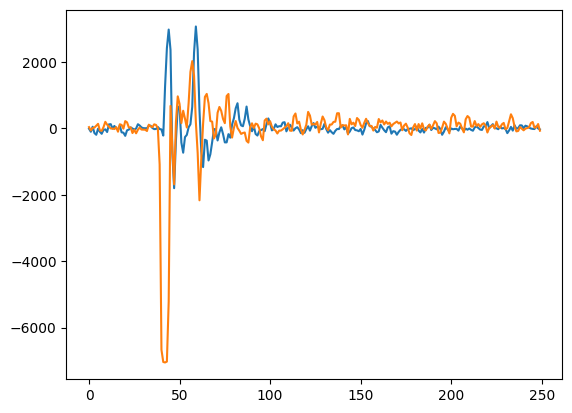

In [4]:
# Sample 1 train and 1 test
r1, r2 = np.random.choice(100000, 2)
print(r1, r2)
X1 = train_data[r1]
X2 = test_data[r2]

print(X1)

plt.plot(X1)
plt.plot(X2)

plt.show()

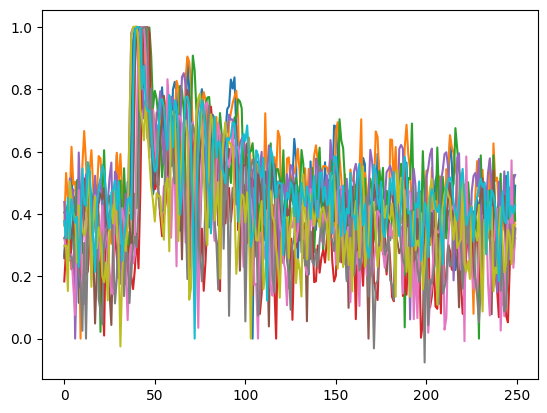

In [5]:
# Testing the logarithmic distortion

eps = 1e-5

for i in range(10):
    X1 = train_data[i]
    
    logX1 = np.log(X1+eps)

    logX1 = (logX1 - logX1.min())/(logX1.max() - logX1.min())

    plt.plot(logX1)
    # plt.plot(X1)

plt.show()

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
sample_size = 502

pos_ids = [np.where(train_label[:,1] == i) for i in range(params.num_pos)]
dev_ids = [np.where(train_label[:,0] == i) for i in range(params.num_dev)]

all_data = []
for i in range(params.num_dev) :
    all_data.append([])
    for k in range(params.num_pos) :
        # Make the union between dev and pos befor getting the time separation
        inter_ids = list(set(dev_ids[i][0]) & set(pos_ids[k][0]))
        inter_ids = inter_ids[:sample_size]
        # Abs of complex value
        all_data[i].append([list(map(np.abs, train_data[inter_ids[j]])) for j in range(len(inter_ids))])

all_data = np.array(all_data)
print(all_data.shape)

(9, 48, 502, 250)


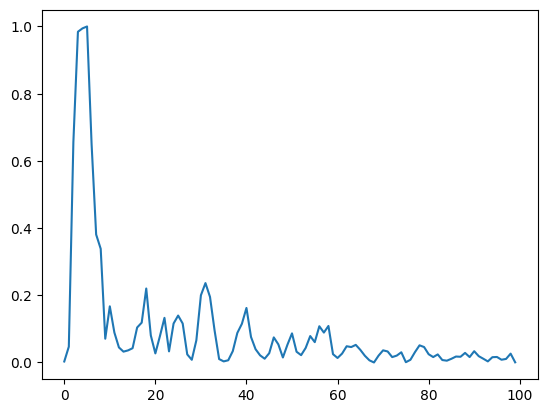

In [35]:
def diff_centering(x):
    start = np.argmax(np.diff(x))
    x = x[start-1:start+99]
    x = (x - x.min())/(x.max() - x.min())
    return x

x = diff_centering(all_data[0, 0, 0])
plt.plot(x)
plt.show()

In [43]:
clean_data = []
for i in range(len(all_data)):
    clean_data.append([])
    for j in range(len(all_data[i])):
        # Filter the argmax that is to early
        filtered = list(filter(lambda x: np.argmax(np.diff(x)) > 3, all_data[i, j]))
        if len(filtered) < 500:
            print(len(filtered))
        # Map the centering function
        clean_data[i].append(list(map(diff_centering, filtered[:sample_size-2])))

clean_data = np.array(clean_data)

In [110]:
import matplotlib as mpl
# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

# sns.set_theme(style="darkgrid")
nb_sample = 10

list_mean_values = np.mean(clean_data[:, :, :nb_sample], axis=2)
print(list_mean_values.shape)

dev_todo = [0, 1]
pos_todo = [0, 1]
frame_data = []
for dev in dev_todo:
    for pos in pos_todo:
        for i in range(nb_sample):
            for j in range(len(clean_data[dev, pos, i])):
                frame_data.append([clean_data[dev, pos, i, j], j, dev, pos])

df_data =pd.DataFrame(frame_data, columns=["Amplitude", "Timestep", "Device", "Position"])

inter_pos = cosine_similarity(clean_data[dev_todo[0], pos_todo[0]], clean_data[dev_todo[0], pos_todo[1]])
print("inter_pos", np.mean(inter_pos))
inter_dev = cosine_similarity(clean_data[dev_todo[0], pos_todo[0]], clean_data[dev_todo[1], pos_todo[0]])
print("inter_dev", np.mean(inter_dev))

colors = sns.color_palette("Set2")
print(colors)

# Same device
sns.lineplot(df_data[df_data["Device"]==dev_todo[0]], x="Timestep", y="Amplitude", hue="Position", style="Device", 
             palette=[colors[1], colors[2]])
plt.title("Same device in different positions \n Cosine similarity: {:.3f}".format(np.mean(inter_pos)))
plt.savefig('/home/thibaua25/Documents/slide factory/Fingerprints/signal_same_position.png', dpi=200)
plt.show()
sns.lineplot(df_data[df_data["Position"]==pos_todo[0]], x="Timestep", y="Amplitude", hue="Device", style="Position",
             palette=[colors[1], colors[4]])
plt.title("Different devices in same position \n Cosine similarity: {:.3f}".format(np.mean(inter_dev)))
plt.savefig('/home/thibaua25/Documents/slide factory/Fingerprints/signal_same_device.png', dpi=200)
plt.show()

# sns.relplot(data=pd.DataFrame(clean_data[1, 25, :nb_sample]), kind="line")

# plt.plot(list_mean_values[1, 1])
# plt.plot(list_mean_values[1, 20])
# plt.show()

# plt.plot(list_mean_values[1, 1])
# plt.plot(list_mean_values[2, 1])
# plt.show()

(9, 48, 100)
inter_pos 0.8975666368922298
inter_dev 0.9366345160339165
[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


KeyError: 'dev'